In [1]:
import pandas as pd
import numpy as np
from numpy.random import *
import datetime
import math
import os
import matplotlib.pyplot as plt
from pylab import rcParams

plt.style.use('ggplot')
%pylab inline --no-import-all

def row(x):    #行
    return x.reshape(1,-1)

def column(x):     #列
    return x.reshape(-1,1)

def row2array(x):
    return x[0,:]

def column2array(x):
    x=x.T
    return x[0,:]

def lorenz(x, t):   #列ベクトルをarrayに変換してからぶち込む
    s = 10
    r = 28
    b = 8/3
    return np.array([-s*x[0]-x[1], r*x[0]-x[1]-x[0]*x[2], -b*x[2]+x[0]*x[1]])
 
def myoutput(x,t):   #xには、列ベクトルを入れること
    rand = np.random.normal(0, 1, (3, 1))
    dt=0.0001
    x=x + 0.1*rand + dt*dt*rand + dt*rand
    return column(x)


Populating the interactive namespace from numpy and matplotlib


##  Here, we perform estimation simulation using nonlinear dynamics called Lorenz equation.

$$
    \sigma = 10, r = 28, b = \frac{8}{3}
$$

$$
    {\dot{x} = \sigma(y-x)\\
\dot{y} = rx -y-z\\
\dot{z} = -bz + xy
}
$$

[6 4 4]
(301,)
(3, 301)


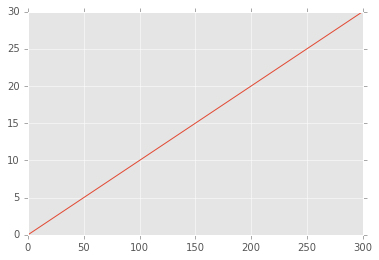

In [2]:
#分散の初期設定
Rtr = 0.3
R = np.diag([0.5, 0.2, 0.1]) #3D
Q = np.diag([2, 4, 3])  #3D
dt = 0.1

# 真値の計算
t = np.linspace(0,30,30/dt+1,dtype=float)#時間　dt=0.01の間隔で0から10秒までの配列
xtr0 = column(np.array([5, 3, 3]))#2D列 #真値の初期値、行列xtr0の1番目の行
ytr0 = myoutput(xtr0,t[0])#2D_列#真値の出力
w0 = np.dot(Q ,np.random.normal(0, 1, (3, 1)))

xtr = xtr0
ytr = ytr0 
w = w0
yt0 = myoutput(xtr0,t[0])#2D_列
yt = yt0

for i in range(1,len(t)):
    k1 = lorenz(xtr[:,i-1], t[i-1] ) #array
    k2 = lorenz(xtr[:,i-1] + dt*k1/2, t[i-1]+dt/2 )   #array
    k3 = lorenz(xtr[:,i-1] +dt*k2/2, t[i-1]+dt/2)   #array
    k4 = lorenz(xtr[:,i-1] +dt*k3,t[i-1]+dt)    #array
    
    w_i = np.dot(Q ,np.random.normal(0, 1, (3, 1)))#3x3と行ベクトルの内積で列ベクトルになる　
    w = np.concatenate([w,w_i],axis=1)    
    
    xtr_i = column(xtr[:,i-1]  + dt* (k1+2*k2+2*k3+k4) /6 ) +column(w[:,i-1].T*dt)
    xtr = np.concatenate([xtr,xtr_i],axis=1) #列を横に並べる

    ytr_i = myoutput(column(xtr[:,i-1]),t[i-1])#2D_列
    ytr = np.concatenate([ytr,ytr_i],axis=1) #列を横に並べる
    
    ###   観測値の計算   ###
    yt_i = ytr_i+column(np.dot(R,np.random.normal(0, 1, (3, 1))))  
    yt = np.concatenate([yt,yt_i],axis=1)    #3D_行
    

len_y = ytr.shape[0]
len_x = ytr.shape[1]


print(xtr0[:,0]+1)
print(t.shape)
print(yt.shape)

# 配列  をプロット
plt.plot(t)
plt.show()

In [3]:
#  EnKFの初期設定
M = 100   #サンプルの数
barx0 = column(np.array([2,10,1]))  #状態の初期値 2D_列
P0 = np.diag([1, 3, 3])  #共分散行列の初期値  3D

# アンサンブル行列X_0/tの作成
x0=column(barx0) #2D_列
# アンサンブル行列Y_0/tの作成
y0 = myoutput( column(x0[:,0]), t[0])  
for i in range(M-1):
        x0_i=barx0 + np.dot(Q,np.random.normal(0, 1, (3, 1))) #2D_列　正規乱数
        x0 = np.concatenate([x0,x0_i],axis=1) #3D_列
        y0_i=myoutput( column(x0[:,0]), t[0]) + np.dot(Q,np.random.normal(0, 1, (3, 1))) 
        y0 = np.concatenate([y0,y0_i],axis=1) #3D_列

 


print(x0.shape)
print(y0.shape)

(3, 100)
(3, 100)


In [4]:
#Ensemble Kalman Filterの計算

#誤差アンサンブル行列の作成

yest=column(ytr[:,0])

for i in range(len(t)-1):
    x=np.array([[0],[0],[0]])
    ### EnKF: 観測更新ステップ ###
    xhat = column(numpy.sum(x0,axis=1) / M ) #2D_列
    yhat = column(numpy.sum(y0,axis=1) / M ) #2D_列
    yest_i = yhat
    yest = np.concatenate([yest,yest_i],axis=1) #3D_列
    Pxy = np.dot( (np.kron(np.eye(1,100),xhat) - x0), (np.kron(np.eye(1,100),yhat) - y0).T ) / (M-1)  #(3x3)  U 共分散行列
    Pyy = np.dot( (np.kron(np.eye(1,100),yhat) - y0), (np.kron(np.eye(1,100),yhat) - y0).T ) / (M-1)  #(3x3)  V 共分散行列
    K = np.dot(Pxy, np.linalg.inv(Pyy))     #np.linalg.inv(A) Aの逆行列 カルマンゲイン  #(3x3)
    
    ### EnKF: 予測更新ステップ  ###
    for j in range(M-1):
        x_j = column( x0[:,j] + np.dot(K, yt[:,i] - y0[:,j]) ) #2D_列
        x = np.concatenate([x,x_j],axis=1) #3D_列
        x0[:,j] = x[:,j] + column2array(row(lorenz(x[:,j], t[i])).T*dt +np.dot(Q,np.random.normal(0, 1, (3, 1))) * dt )  #array型
        
        y0[:,j] = column2array(  myoutput(column(x0[:,j]),t[i]) + np.dot(R, np.random.normal(0, 1, (3, 1)) ) )    #array型

            

In [5]:
print(t.shape)  #(201,) tの真値
print(xtr.shape)  #(3, 201) xの真値
print(ytr.shape)  #(3, 201) yの真値
print(yest.shape)  #(3, 201) yestの真値 #便宜上t=0　を挿入している。

(301,)
(3, 301)
(3, 301)
(3, 301)


In [6]:
df = pd.DataFrame({ 't' : t ,
                    'xtr1' : xtr[0,:],
                    'xtr2' : xtr[1,:],
                    'xtr3' : xtr[2,:],
                    'ytr1' : ytr[0,:],
                    'ytr2' : ytr[1,:],
                    'ytr3' : ytr[2,:],
                    'yest1' : yest[0,:],
                    'yest2' : yest[1,:],
                    'yest3' : yest[2,:],
                  })
df[:10]

,t,xtr1,xtr2,xtr3,yest1,yest2,yest3,ytr1,ytr2,ytr3
0,0.0,5.000000,3.000000,3.000000,4.927740,3.054393,2.894979,4.927740,3.054393,2.894979
1,0.1,1.711851,9.309797,3.220061,1.946589,9.258151,1.290937,4.812369,2.978483,2.900472
2,0.2,0.576851,10.655329,3.021378,-0.489549,7.340032,1.497667,1.757144,9.222707,3.188964
3,0.3,-0.838260,9.400678,2.763035,-0.548537,11.128899,2.458734,0.619847,10.658798,2.979034
4,0.4,-0.716400,6.742739,1.084257,-1.026611,10.995244,2.531411,-0.806381,9.515377,2.815742
5,0.5,-0.787232,5.082424,0.990463,-1.085028,9.097837,1.495058,-0.701472,6.754862,1.065278
6,0.6,-0.362734,3.199998,0.406706,-1.013335,7.671250,1.033858,-0.779016,5.128771,1.006917
7,0.7,-0.270213,1.994700,0.287945,-0.603724,4.163843,0.287436,-0.417694,3.003722,0.455016
8,0.8,-0.069223,1.264020,0.168950,-0.436054,2.656422,0.199313,-0.334547,1.943915,0.347034
9,0.9,0.015530,0.789941,-0.152363,-0.221976,1.256548,0.127511,-0.086852,1.234425,0.317198


/home/ec2-user/.pyenv/versions/anaconda3-4.0.0/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/ec2-user/.pyenv/versions/anaconda3-4.0.0/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


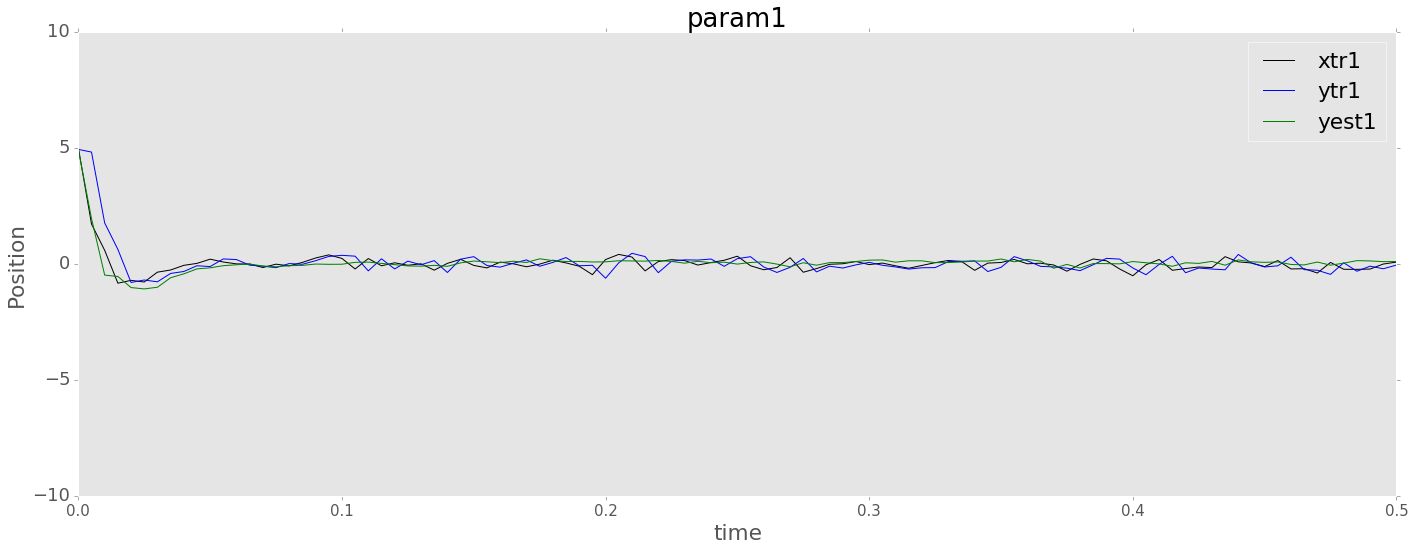

In [7]:
from matplotlib import cm
import matplotlib.dates as mdates
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

rcParams['figure.figsize'] = 20,8
plt.rcParams["font.size"] = 18


input1 = df['t']
output0 = df['xtr1']
output1 = df['ytr1']
output2 = df['yest1']

fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
ax1.plot(input1, output0, color='black',linestyle='solid', linewidth = 1, label='xtr1')
ax1.plot(input1, output1, color='blue',linestyle='solid', linewidth = 1, label='ytr1')
ax1.set_xlim([0, 10])
ax1.set_ylim([-10, 10])
ax1.plot(input1, output2, color='green', linewidth = 1, label='yest1')
ax1.set_title('param1')
ax1.set_xlabel('time')
ax1.set_ylabel('Position')
ax1.set_xticklabels(input1,rotation=0, size="small")


plt.legend()

ax1.grid(False) #目盛のごちゃごちゃ変更

fig.show()

/home/ec2-user/.pyenv/versions/anaconda3-4.0.0/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/ec2-user/.pyenv/versions/anaconda3-4.0.0/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


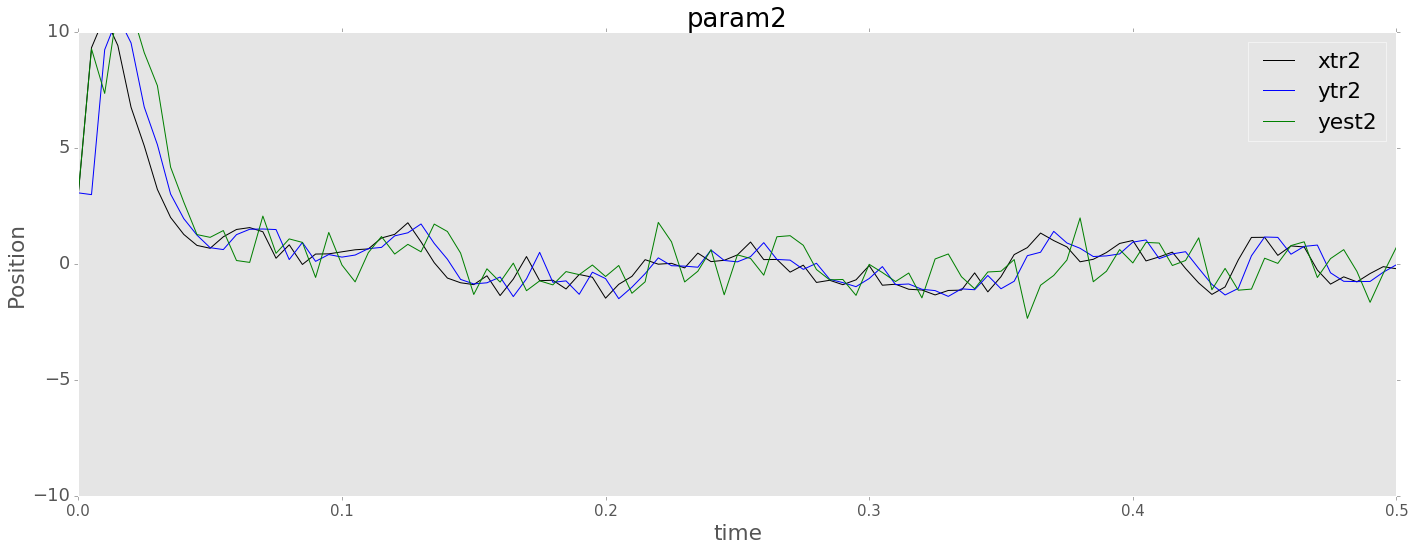

In [8]:
rcParams['figure.figsize'] = 20,8
plt.rcParams["font.size"] = 18


input1 = df['t']
output0 = df['xtr2']
output1 = df['ytr2']
output2 = df['yest2']

fig2 = plt.figure()
ax2 = fig2.add_subplot(1,1,1)
ax2.plot(input1, output0, color='black',linestyle='solid', linewidth = 1, label='xtr2')
ax2.plot(input1, output1, color='blue',linestyle='solid', linewidth = 1, label='ytr2')
ax2.set_xlim([0, 10])
ax2.set_ylim([-10, 10])
ax2.plot(input1, output2, color='green', linewidth = 1, label='yest2')
ax2.set_title('param2')
ax2.set_xlabel('time')
ax2.set_ylabel('Position')
ax2.set_xticklabels(input1,rotation=0, size="small")


plt.legend()

ax2.grid(False) #目盛のごちゃごちゃ変更

fig2.show()

/home/ec2-user/.pyenv/versions/anaconda3-4.0.0/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/ec2-user/.pyenv/versions/anaconda3-4.0.0/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


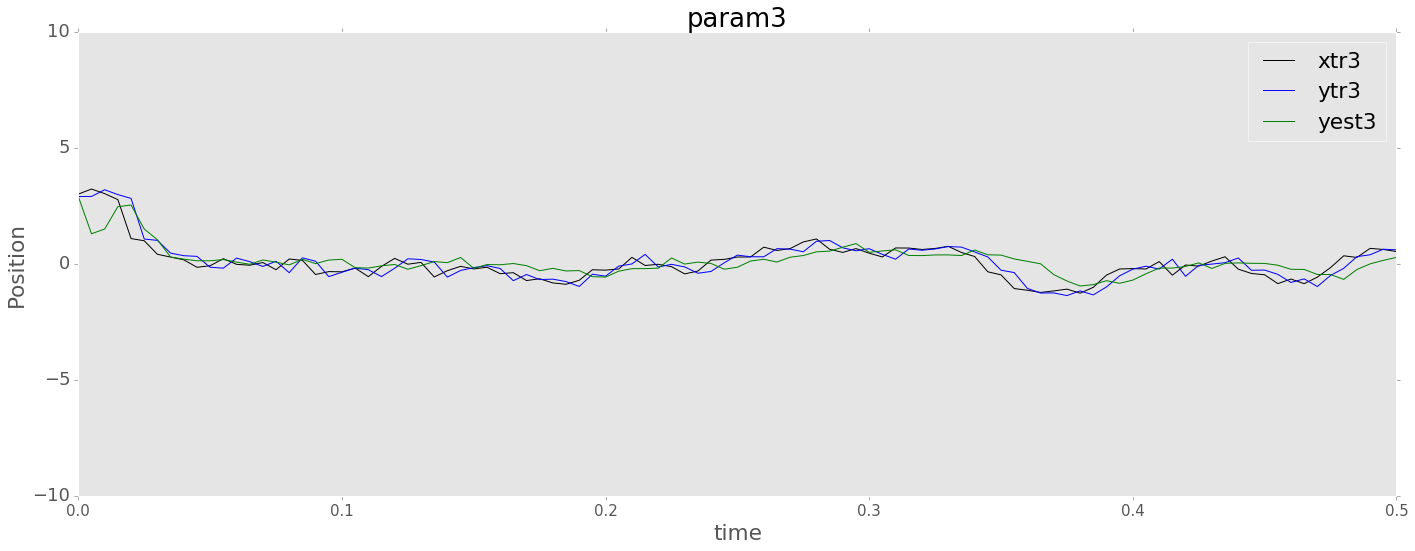

In [9]:
rcParams['figure.figsize'] = 20,8
plt.rcParams["font.size"] = 18


input1 = df['t']
output0 = df['xtr3']
output1 = df['ytr3']
output2 = df['yest3']

fig3 = plt.figure()
ax3 = fig3.add_subplot(1,1,1)
ax3.plot(input1, output0, color='black',linestyle='solid', linewidth = 1, label='xtr3')
ax3.plot(input1, output1, color='blue',linestyle='solid', linewidth = 1, label='ytr3')
ax3.set_xlim([0, 10])
ax3.set_ylim([-10, 10])
ax3.plot(input1, output2, color='green', linewidth = 1, label='yest3')
ax3.set_title('param3')
ax3.set_xlabel('time')
ax3.set_ylabel('Position')
ax3.set_xticklabels(input1,rotation=0, size="small")


plt.legend()

ax3.grid(False) #目盛のごちゃごちゃ変更

fig3.show()